# Workflows - Prompt Chaining

## What are workflows?

To recap, workflows are systems where LLMs and tools are orchestrated through predefined code paths.

## What is Routing?

[According to Anthropic](https://www.anthropic.com/research/building-effective-agents), routing classifies an input and directs it to a specialized followup task. This workflow allows for separation of concerns, and building more specialized prompts. Without this workflow, optimizing for one kind of input can hurt performance on other inputs.

## Implementation & use case

In this notebook, we will implement a routing workflow. We will be building on top of the previously defined workflow on the [2-Workflows-Prompt-Chaining.ipynb](2-Workflows-Prompt-Chaining.ipynb) notebook and will add one extra step. To summarize what the workflow will do:

1. Load local pdf files.
2. Summarize the files
3. Extract the main topics
4. Based on what the user request we will invoke an LLM with a different prompt to adjust the final response according to the user preferences. There will be 3 possible options: formal, short and casual. We will use schema validation for this.

This is how it should look like after implementing it:

![workflow-prompt-chaining](images/workflow-routing.png)

We will use LangChain to abstract away the LLM integration and we will use LangGraph to build the workflows.

## Building the workflow

Let's start by installing some dependencies

In [ ]:
%pip install -r requirements.txt

Since we already have the `FileContent`, `FileSummary` classes, we can import them and use them straight away.

Let's define the shared State for LangGraph.

This State will need to store:
1. The input from the user
2. A list of files we want to use
3. The content of said files. We can use the `FileContent` class to store this data.
4. The summarized pieces of content, with its title. We can use the `Section` class for it.
5. The choice made by the LLM. We will use it to route to the different code paths.
6. The output we want to print.

In [1]:
from pydantic import BaseModel
from typing import List
from utils import FileContent, FileSummary, read_files, summarize_files, identify_main_topics

# Initializing empty state
class State(BaseModel):
    file_list: List[str] = []
    file_contents: List[FileContent] = []
    summarized_files: List[FileSummary] = []
    user_input: str = ""
    decision: str = ""
    output: str = ""

We will need to define a function to invoke an LLM to make a decision to route based on user input.

Forcing LLMs to output with a specific schema will be very useful, as we want the routing LLM response to be within a specific list of options.


In [2]:
from pydantic import BaseModel, Field
from typing import Literal, Dict
from langchain_core.language_models import BaseLanguageModel

class Route(BaseModel):
    step: Literal["formal", "short", "casual"] = Field(
        None, description="The next step in the routing process"
    )

def route(user_input: str, llm: BaseLanguageModel) -> str:

    """
    Use an LLM to decide best routing option based on user input
    
    Args:
        user_input(str): the input from the user
        llm (BaseLanguageModel): the LLM
        
    Returns:
        decision(str): the decision made by the LLM
    """

    structured_llm = llm.with_structured_output(Route)

    prompt = f"""
    Analyze the input and select the most appropriate option.
    Only select from within these options:
    - formal: longer, formal responses
    - short: more concise, shorter responses
    - casual: casual responses, using emojis where possible
    Only answer with a single word, lowercase, from the list above.
    Input: {user_input}"""

    decision = structured_llm.invoke(prompt)

    return decision

We will also define 3 functions to generate responses with an LLM based on the user preferences.

In [3]:
def generate_formal_response(summary_list: List[FileSummary], llm: BaseLanguageModel) -> str:
    """
    Generates a "formal" response with an LLM. 
    
    Args:
        summary_list: List[FileSummary]: the list of summaries to from which generate the response
        llm (BaseLanguageModel): the LLM to use

    Returns:
        response[str]: the response from the LLM
    """

    prompt = f"""

    <text>{summary_list}</text>

    Analyze the text contained within the <text> tags and generate
    a summary on the main topics across all text.
    Use a formal, academic tone.
    Include only the summary in your response, nothing else.
    """

    text = '\n'.join(
        f"{section.title}: {section.summary}"
        for file_summary in summary_list
        for section in file_summary.sections
    )

    response = llm.invoke(prompt)

    return response.content

def generate_short_response(summary_list: List[FileSummary], llm: BaseLanguageModel) -> str:
    """
    Generates a "shorter" response with an LLM. 
    
    Args:
        summary_list: List[FileSummary]: the list of summaries to from which generate the response
        llm (BaseLanguageModel): the LLM to use

    Returns:
        response[str]: the response from the LLM
    """

    prompt = f"""

    <text>{summary_list}</text>

    Analyze the text contained within the <text> tags and generate
    a short summary on the main topics across all text.
    Be succint and only talk about the main topics
    Include only the summary in your response, nothing else.
    """

    text = '\n'.join(
        f"{section.title}: {section.summary}"
        for file_summary in summary_list
        for section in file_summary.sections
    )

    response = llm.invoke(prompt)

    return response.content

def generate_casual_response(summary_list: List[FileSummary], llm: BaseLanguageModel) -> str:
    """
    Generates a "casual" response with an LLM. 
    
    Args:
        summary_list: List[FileSummary]: the list of summaries to from which generate the response
        llm (BaseLanguageModel): the LLM to use

    Returns:
        response[str]: the response from the LLM
    """

    prompt = f"""

    <text>{summary_list}</text>

    Analyze the text contained within the <text> tags and generate
    a summary on the main topics across all text.
    Use a casual tone, and mix in emojis to make the text more interesting.
    Include only the summary in your response, nothing else.
    """

    text = '\n'.join(
        f"{section.title}: {section.summary}"
        for file_summary in summary_list
        for section in file_summary.sections
    )

    response = llm.invoke(prompt)

    return response.content

Since we already have the  `read_files` and `summarize_files` functions defined, we can import them and use them straight away.

Lets build some wrapper functions that will act as nodes in the Graph.

In [4]:
import asyncio

async def load_files(state: State) -> Dict:
    return {"file_contents": await read_files(state.file_list)}

def router(state: State) -> Dict:
    return {"decision": route(state.user_input, llm).step}

def route_decision(state: State) -> Dict:
    if state.decision == 'formal':
        return "formal"
        #return "formal_response"
    elif state.decision == 'short':
        return "short"
        #return "short_response"
    elif state.decision == 'casual':
        return "casual"
        #return "casual_response"

def summarize_all_files(state: State) -> Dict:
    return {"summarized_files": summarize_files(file_list=state.file_contents, llm=llm)}

def iden_main_topics(state: State) -> Dict:
    return {"main_topics": identify_main_topics(state.summarized_files, llm=llm)}

def formal_response(state: State) -> Dict:
    return {"output": generate_formal_response(state.summarized_files, llm=llm)}

def short_response(state: State) -> Dict:
    return {"output": generate_short_response(state.summarized_files, llm=llm)}

def casual_response(state: State) -> Dict:
    return {"output": generate_casual_response(state.summarized_files, llm=llm)}


Let's build the Graph

In [5]:
from langgraph.graph import StateGraph, START, END

# Build the state graph
builder = StateGraph(State)

# add nodes
builder.add_node("Load files", load_files)
builder.add_node("Summarize files", summarize_all_files)
builder.add_node("Identify main topics", iden_main_topics)
builder.add_node("Router node", router)
builder.add_node("formal_response", formal_response)
builder.add_node("short_response", short_response)
builder.add_node("casual_response", casual_response)

builder.add_edge(START, "Load files")
builder.add_edge("Load files", "Summarize files")
builder.add_edge("Summarize files", "Identify main topics")
builder.add_edge("Identify main topics", "Router node")
# Conditional edges
builder.add_conditional_edges(
    "Router node",
    route_decision,
    {
        "formal": "formal_response",
        "short": "short_response",
        "casual": "casual_response"
    }
)
builder.add_edge("formal_response", END)
builder.add_edge("short_response", END)
builder.add_edge("casual_response", END)


graph = builder.compile()

We have built the graph! We can take advantage of a feature in LangGraph to see how it looks like.

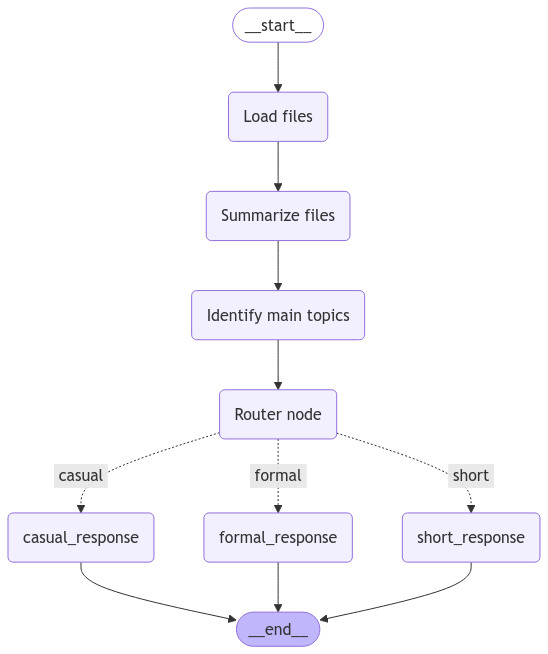

In [7]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

Looks all right! Let's load some files and test it

We will load the files using the `load_files` function we defined on the first notebook. You can head to [Directly calling LLMs](1-DirectCall.ipynb) for more info about this function.

In [8]:
import os 

base_dir = os.path.expanduser('~/Desktop/pdfs')

input_files = \
    [
        os.path.join(base_dir, "1.pdf"),
        os.path.join(base_dir, "2.pdf"),
        os.path.join(base_dir, "3.pdf"),
        os.path.join(base_dir, "4.pdf"),
        os.path.join(base_dir, "5.pdf")
]

Let's define the LLM we will use. I am using a local LLM hosted with LM Studio that has an OpenAI compatible API. You can change the below line to whatever LLM you want to use.

In [9]:
from utils import load_llm
llm = load_llm()

Loading LLM...
Parameters:
max_tokens: 8192, temperature: 0.1, top_p: 0.4
Using Anthropic. Model: claude-3-5-haiku-20241022


## Time to test it!

We have now everything we need to test the graph. Let's test it!

In [ ]:
result = await graph.ainvoke(
    {
        "file_list": input_files,
        "user_input": "I like fun, casual and interesting reads."
    }
)

Let's check the results:

In [11]:
result['decision'], result['output']

('casual',
 "Hey there! 🚀 Here's a quick rundown of the key topics across these documents:\n\nAI and Machine Learning Deep Dive 🤖\nThe texts cover several fascinating areas of AI technology, including:\n- LangGraph: A powerful framework for creating complex AI agent workflows 📊\n- Large Language Model (LLM) Training Fundamentals 🧠\n- Emerging AI Reasoning Techniques 🔍\n- Transformers Library: A versatile tool for machine learning tasks 💻\n\nKey Highlights:\n- Breakthrough research in low-cost AI model training 💡\n- Advanced techniques for teaching AI to reason and solve problems 🧩\n- Tools for building interactive, dynamic AI systems 🤝\n- Exploration of how AI can develop more human-like cognitive processes 🌟\n\nIndustry Trends:\n- AI productivity tools 📈\n- Innovations from companies like Mistral, LinkedIn, and OpenAI 🌐\n- Emerging technologies in image generation and text-based AI 🖼️\n\nThe documents showcase an exciting landscape of AI development, focusing on making AI more intelli